In [1]:
import sys
sys.path.insert(0, '..')

In [2]:
# Basic imports
import jax.numpy as np
import jax.random as jr
import jax.scipy as jsp
import jax
import numpy

#jax.config.update("jax_enable_x64", True)

# Optimisation imports
import zodiax as zdx
import optax

# dLux imports
import dLux as dl
import dLux.utils as dlu

# Visualisation imports
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib

plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 72

from detectors import *
from apertures import *
from models import *
from fisher import *
from stats import posterior

%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 72
plt.rcParams["font.size"] = 24

def set_array(pytree):
    dtype = np.float64 if jax.config.x64_enabled else np.float32
    floats, other = eqx.partition(pytree, eqx.is_inexact_array_like)
    floats = jtu.tree_map(lambda x: np.array(x, dtype=dtype), floats)
    return eqx.combine(floats, other)

In [3]:
wid = 150
oversample = 4

optics = NICMOSOptics(512, wid, oversample)

detector = NICMOSDetector(oversample, wid)
ddir = "../data/MAST_2024-08-27T07_49_07.684Z/"
#ddir = '../data/MAST_2024-07-07T03_17_36.223Z/'
#fname = ddir + 'HST/n8ku01050_mos.fits'
#fname = ddir + 'HST/n8ku01ffq_cal.fits'
ddir = "../data/MAST_2024-09-08T07_59_18.213Z/"
fname = ddir + 'HST/n43ca5feq_cal.fits'
#fname = ddir + 'HST/n43ca5fkq_cal.fits'

new_nans = True

if new_nans:
    bad = np.zeros((wid,wid), dtype=int)

ddir = '../data/MAST_2024-09-18T07_29_05.659Z/HST/'

data = '../data/MAST_2024-09-18T21_00_06.099Z/HST/'

# Ghez GG Tau
ddir = '../data/MAST_2024-10-25T11_21_27.458Z/HST/'

# all the T Tarui binaries with polarimetry

ddir = '../data/MAST_2024-10-26T05_54_04.515Z/HST/'

exposures = [
    #exposure_from_file(ddir + 'HST/n43c05f9q_cal.fits', BinaryFit(), crop=wid, extra_bad=bad),
    #exposure_from_file(ddir + 'HST/n43c05fbq_cal.fits', BinaryFit(), crop=wid, extra_bad=bad),
    #exposure_from_file(ddir + 'HST/n43c02dcq_cal.fits', BinaryFit(), crop=wid, extra_bad=bad),

    # gg tau
    #exposure_from_file(ddir + 'n4lp04elq_cal.fits', BinaryFit(), crop=wid),


    #exposure_from_file(ddir + 'n42x01cpq_cal.fits', BinaryFit(), crop=wid),
    #exposure_from_file(ddir + 'n42x01cqq_cal.fits', BinaryFit(), crop=wid),

    #exposure_from_file(ddir + 'n42x01czq_cal.fits', BinaryFit(), crop=wid),
    #exposure_from_file(ddir + 'n42x01d0q_cal.fits', BinaryFit(), crop=wid),
    #exposure_from_file(ddir + 'n42x01d1q_cal.fits', BinaryFit(), crop=wid),

    # uy aur

    #exposure_from_file(ddir + 'n4lp11qwq_cal.fits', BinaryFit(), crop=wid),
    #exposure_from_file(ddir + 'n4lp11r0q_cal.fits', BinaryFit(), crop=wid),

    # v807 tau

    exposure_from_file(ddir + 'n4lp08jwq_cal.fits', BinaryFit(), crop=wid),




    #exposure_from_file(ddir + 'n4lp04070_mos.fits', BinaryFit(), crop=wid),

    # xz tau
    #exposure_from_file(data+'n4lp05bmq_cal.fits', BinaryFit(), crop=wid),
    #exposure_from_file(data+'n4lp05bpq_cal.fits', BinaryFit(), crop=wid),
    #exposure_from_file(data+'n4lp05btq_cal.fits', BinaryFit(), crop=wid)
]

Filename: ../data/MAST_2024-10-26T05_54_04.515Z/HST/n4lp08jwq_cal.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     305   ()      
  1  SCI           1 ImageHDU       143   (256, 256)   float32   
  2  ERR           1 ImageHDU        71   (256, 256)   float32   
  3  DQ            1 ImageHDU        71   (256, 256)   int16   
  4  SAMP          1 ImageHDU        71   (256, 256)   int16   
  5  TIME          1 ImageHDU        71   (256, 256)   float32   
None


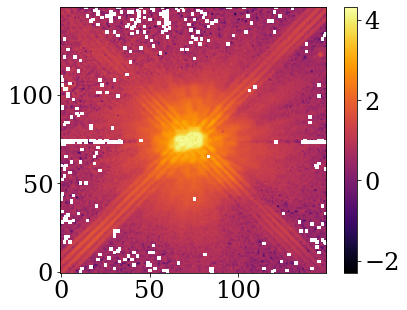

In [4]:
plt.imshow(np.log10(exposures[0].data/exposures[0].err))
plt.colorbar()

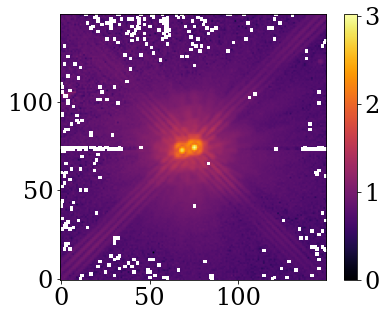

In [5]:
plt.imshow(exposures[0].data**0.125)
plt.colorbar()

In [ ]:
params = {
    "fluxes": {},
    "positions": {},
    "contrast": {},
    "separation": 8.,#24.,#6.,#6.,
    "position_angle": 80., #0.,#45.,#30.,#30.,#80.,#40.,
    "aberrations": {},
    "cold_mask_shift": {},
    "cold_mask_rot": {},
    "cold_mask_scale": {},
    "cold_mask_shear": {},
    "primary_scale": {},
    "primary_rot": {},
    "primary_shear": {},
    "slope": {},
    "outer_radius": 1.2*0.955,
    "secondary_radius": 0.372*1.2,
    "spider_width": 0.077*1.2,
    "scale": 0.0434735,
    "rot": 0.0
}

for exp in exposures:
    params["positions"][exp.fit.get_key(exp, "positions")] = np.asarray([-3.,-2.])#np.asarray([0.,-12.])#np.asarray([3,2.])#np.asarray([3.,2.])#np.asarray([-3.,-2.])##np.asarray([-8.,-2.])#np.asarray([-6.,-7.])
    params["fluxes"][exp.fit.get_key(exp, "fluxes")] = np.log10(np.nansum(exp.data)/2)
    params["slope"][exp.fit.get_key(exp, "slope")] = np.zeros(5)#.at[0].set(1)
    #params["aberrations"] = injected_params["aberrations"]
    params["aberrations"][exp.fit.get_key(exp, "aberrations")] = np.zeros(26)#jr.uniform(jr.key(0), (8,),minval=-4e-8, maxval=4e-8) #np.asarray([-8.59023084e-10,  1.77049982e-09, -4.45293089e-09, -3.70890613e-08,2.03658617e-08,  1.08092528e-08, -2.77077727e-09,  1.86458672e-09])*0.9#jr.uniform(jr.key(0), (8,),minval=-2e-8, maxval=2e-8)#np.zeros(8)#np.ones(8)*1e-8
    params["cold_mask_shift"][exp.fit.get_key(exp, "cold_mask_shift")] = np.asarray([0.06, 0.06])*1e2
    params["cold_mask_rot"][exp.fit.get_key(exp, "cold_mask_rot")] = 45.
    params["cold_mask_scale"][exp.fit.get_key(exp, "cold_mask_scale")] = np.asarray([1.,1.])
    params["cold_mask_shear"][exp.fit.get_key(exp, "cold_mask_shear")] = np.asarray([0.,0.])
    params["primary_rot"][exp.fit.get_key(exp, "primary_rot")] = 45.
    params["primary_scale"][exp.fit.get_key(exp, "primary_scale")] = np.asarray([1.,1.])
    params["primary_shear"][exp.fit.get_key(exp, "primary_shear")] = np.asarray([0.,0.])
    params["contrast"][exp.fit.get_key(exp, "contrast")] = 1.


model = set_array(NICMOSModel(exposures, params, optics, detector))

params = ModelParams(params)

In [7]:
def grid_loss(params,exposures):
    mdl = params.inject(model)
    return np.nansum(np.asarray([posterior(mdl,exposure) for exposure in exposures]))

def test_model(s, a, x, y, c):
    for exp in exposures:
        params["contrast"][exp.fit.get_key(exp, "contrast")] = c
        params["positions"][exp.fit.get_key(exp, "positions")] = np.asarray([x,y])
        params["position_angle"] = a
        params["separation"] = s
    prms = ModelParams(params)
    loss = grid_loss(prms, exposures)
    return loss#, prms


In [8]:
pos_x = np.linspace(-3, 3, 2)
pos_y = np.linspace(-3, 3, 2)
contrast = np.asarray([1.])

#py, cs = np.meshgrid( pos_y, contrast)
#px = px.flatten()
#py = py.flatten()
#cs = cs.flatten()

best_params = None
best_loss = np.inf

tmc = jax.vmap(test_model, (None, None, None, None, 0))

"""
for x in (pos_x):
    for y in tqdm(pos_y):



        losses = tmc(s,a,x,y,contrast)
        mn = np.argmin(losses)
        bl = np.min(losses)
        if bl < best_loss:
            best_loss = bl
            for exp in exposures:
                params["contrast"][exp.fit.get_key(exp, "contrast")] = contrast[mn]
                params["positions"][exp.fit.get_key(exp, "positions")] = np.asarray([x,y])
                params["position_angle"] = a
                params["separation"] = s
            best_params = ModelParams(params)

                for c in contrast:
                    loss, prms = test_model(s,a, x, y, c)
                    if loss < best_loss:
                        best_loss = loss
                        best_params = prms

#params = best_params
"""



'\nfor x in (pos_x):\n    for y in tqdm(pos_y):\n\n\n\n        losses = tmc(s,a,x,y,contrast)\n        mn = np.argmin(losses)\n        bl = np.min(losses)\n        if bl < best_loss:\n            best_loss = bl\n            for exp in exposures:\n                params["contrast"][exp.fit.get_key(exp, "contrast")] = contrast[mn]\n                params["positions"][exp.fit.get_key(exp, "positions")] = np.asarray([x,y])\n                params["position_angle"] = a\n                params["separation"] = s\n            best_params = ModelParams(params)\n\n                for c in contrast:\n                    loss, prms = test_model(s,a, x, y, c)\n                    if loss < best_loss:\n                        best_loss = loss\n                        best_params = prms\n\n#params = best_params\n'

In [9]:
#best_params.params["contrast"]

In [10]:
#params = best_params

In [11]:
#print(params.params["contrast"])

In [12]:
def scheduler(lr, start, *args):
    shed_dict = {start: 1e10}
    for start, mul in args:
        shed_dict[start] = mul
    return optax.piecewise_constant_schedule(lr / 1e10, shed_dict)

base_sgd = lambda vals: optax.sgd(vals, nesterov=True, momentum=0.6)

opt = lambda lr, start, *schedule: base_sgd(scheduler(lr, start, *schedule))

base_adam = lambda vals: optax.adam(vals)
opta = lambda lr, start, *schedule: base_adam(scheduler(lr, start, *schedule))


def flatten(l):
    if isinstance(l, (tuple, list)):
         return [a for i in l for a in flatten(i)]
    else:
        return [l]



g = 1e-3

things = {
    "fluxes" : opt(g*300,20),
    "positions": opt(g*30, 0),
    "slope": opt(g*100, 60),
    "cold_mask_shift": opt(g*500, 150),
    "cold_mask_scale": opt(g*500, 150),
    "cold_mask_rot": opt(g*500, 150),
    #"cold_mask_shear": opt(g*1000, 200),
    #"primary_scale": opt(g*1000, 200),
    #"primary_rot": opt(g*1000, 200),
    #"primary_shear": opt(g*1000, 200),
    "aberrations": opt(g*3,150),
    "separation": opt(g*100, 0),
    "contrast": opt(g*100, 20),
    "position_angle": opt(g*100, 0)
    #"rot": opt(g*100, 50),
}

groups = list(things.keys())
paths = flatten(groups)
optimisers = [things[i] for i in groups]
groups = [list(x) if isinstance(x, tuple) else x for x in groups]

In [13]:
@zdx.filter_jit
@zdx.filter_value_and_grad(paths)
def loss_fn(params,exposures):
    mdl = params.inject(model)
    return np.nansum(np.asarray([posterior(mdl,exposure) for exposure in exposures]))


In [14]:
rc = False
fishers = calc_fishers(model, exposures, paths, recalculate=rc)
lrs = calc_lrs(model, exposures, fishers, paths)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [15]:
lrs.params

{'aberrations': {'n4lp08jwq': Array([ 1.0747985e-06,  1.3458131e-06,  8.6801617e-07, -9.8533965e-06,
         -2.4345763e-06, -6.1798926e-07, -5.4956558e-07,  1.5740014e-06,
          4.9114988e-07,  7.6022963e-07,  9.8501505e-07,  8.5686793e-07,
          1.3665418e-06,  1.1846208e-06, -1.6426480e-05,  2.6873951e-05,
          1.5854432e-06,  1.7079519e-06,  6.1488942e-07,  5.2022352e-07,
          4.0558058e-07,  4.2241820e-07,  4.7992700e-07,  8.7679234e-07,
          7.6942604e-07,  7.8448977e-07], dtype=float32)},
 'cold_mask_rot': {'POL120S': Array(4.1655768e-10, dtype=float32)},
 'cold_mask_scale': {'POL120S': Array([1.4033758e-13, 1.3287301e-13], dtype=float32)},
 'cold_mask_shear': {'POL120S': None},
 'cold_mask_shift': {'POL120S': Array([7.7589707e-10, 7.5884393e-10], dtype=float32)},
 'contrast': {'POL120S': Array(-8.011661e-11, dtype=float32)},
 'fluxes': {'POL120S': Array(-2.0536225e-12, dtype=float32)},
 'outer_radius': None,
 'position_angle': Array(-2.5482239e-09, dtype

In [16]:
optim, opt_state = zdx.get_optimiser(
    params, groups, optimisers
)


losses, models = [], []
for i in tqdm(range(250)):
    loss, grads = loss_fn(params,exposures)
    grads = jtu.tree_map(lambda x, y: x * np.abs(y), grads, ModelParams(lrs.params))
    updates, opt_state = optim.update(grads, opt_state)
    params = zdx.apply_updates(params, updates)

    models.append(params)
    losses.append(loss)


  0%|          | 0/250 [00:00<?, ?it/s]

In [17]:
model


NICMOSModel(
  params={
    'aberrations':
    {'n4lp08jwq': f32[26]},
    'cold_mask_rot':
    {'POL120S': f32[]},
    'cold_mask_scale':
    {'POL120S': f32[2]},
    'cold_mask_shear':
    {'POL120S': f32[2]},
    'cold_mask_shift':
    {'POL120S': f32[2]},
    'contrast':
    {'POL120S': f32[]},
    'fluxes':
    {'POL120S': f32[]},
    'outer_radius':
    f32[],
    'position_angle':
    f32[],
    'positions':
    {'n4lp08jwq': f32[2]},
    'primary_rot':
    {'POL120S': f32[]},
    'primary_scale':
    {'POL120S': f32[2]},
    'primary_shear':
    {'POL120S': f32[2]},
    'rot':
    f32[],
    'scale':
    f32[],
    'secondary_radius':
    f32[],
    'separation':
    f32[],
    'slope':
    {'POL120S': f32[5]},
    'spider_width':
    f32[]
  },
  filters={'POL120S': f32[12,2]},
  optics=NICMOSOptics(
    wf_npixels=512,
    diameter=f32[],
    layers={
      'CompoundAperture':
      CompoundAperture(
        normalise=True,
        transformation=CoordTransform(
          tra

In [18]:
losses

[Array(1.5271945e+10, dtype=float32),
 Array(1.3150771e+10, dtype=float32),
 Array(1.1218819e+10, dtype=float32),
 Array(9.65521e+09, dtype=float32),
 Array(8.4441994e+09, dtype=float32),
 Array(7.5148083e+09, dtype=float32),
 Array(6.7955343e+09, dtype=float32),
 Array(6.229252e+09, dtype=float32),
 Array(5.7740375e+09, dtype=float32),
 Array(5.400088e+09, dtype=float32),
 Array(5.0865055e+09, dtype=float32),
 Array(4.8185713e+09, dtype=float32),
 Array(4.585843e+09, dtype=float32),
 Array(4.380826e+09, dtype=float32),
 Array(4.1980713e+09, dtype=float32),
 Array(4.0335247e+09, dtype=float32),
 Array(3.8841544e+09, dtype=float32),
 Array(3.747627e+09, dtype=float32),
 Array(3.6221243e+09, dtype=float32),
 Array(3.5062147e+09, dtype=float32),
 Array(3.3987287e+09, dtype=float32),
 Array(2.892168e+09, dtype=float32),
 Array(2.59857e+09, dtype=float32),
 Array(2.424869e+09, dtype=float32),
 Array(2.317257e+09, dtype=float32),
 Array(2.246013e+09, dtype=float32),
 Array(2.194933e+09, dtyp

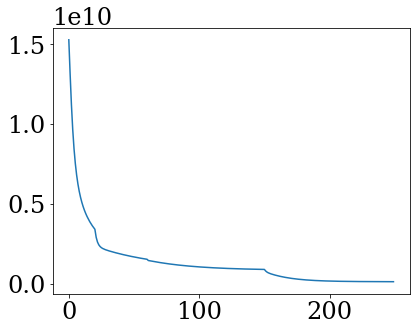

In [19]:
plt.plot(losses)

In [20]:
params.params

{'aberrations': {'n4lp08jwq': Array([-0.40395886,  0.53393495, -0.36544728,  6.736362  , 21.868208  ,
         -0.16236944,  0.68329275, -4.5217524 , -1.2556232 ,  1.2168049 ,
          0.1004691 , -0.1252865 , -8.243903  , -0.22940217,  0.87963974,
         -9.031163  ,  2.0471814 ,  0.78351283, -0.5537588 ,  0.151382  ,
         -0.586899  , -0.09932876, -0.33722758,  0.0934468 , -0.27888587,
         -0.58748424], dtype=float32)},
 'cold_mask_rot': {'POL120S': Array(45.107235, dtype=float32)},
 'cold_mask_scale': {'POL120S': Array([1.0031196, 0.9988337], dtype=float32)},
 'cold_mask_shear': {'POL120S': Array([0., 0.], dtype=float32)},
 'cold_mask_shift': {'POL120S': Array([6.578626 , 6.0089006], dtype=float32)},
 'contrast': {'POL120S': Array(1.6796162, dtype=float32)},
 'fluxes': {'POL120S': Array(4.730415, dtype=float32)},
 'outer_radius': 1.146,
 'position_angle': Array(76.85238, dtype=float32),
 'positions': {'n4lp08jwq': Array([-2.9581642, -1.2542032], dtype=float32)},
 'primar

10


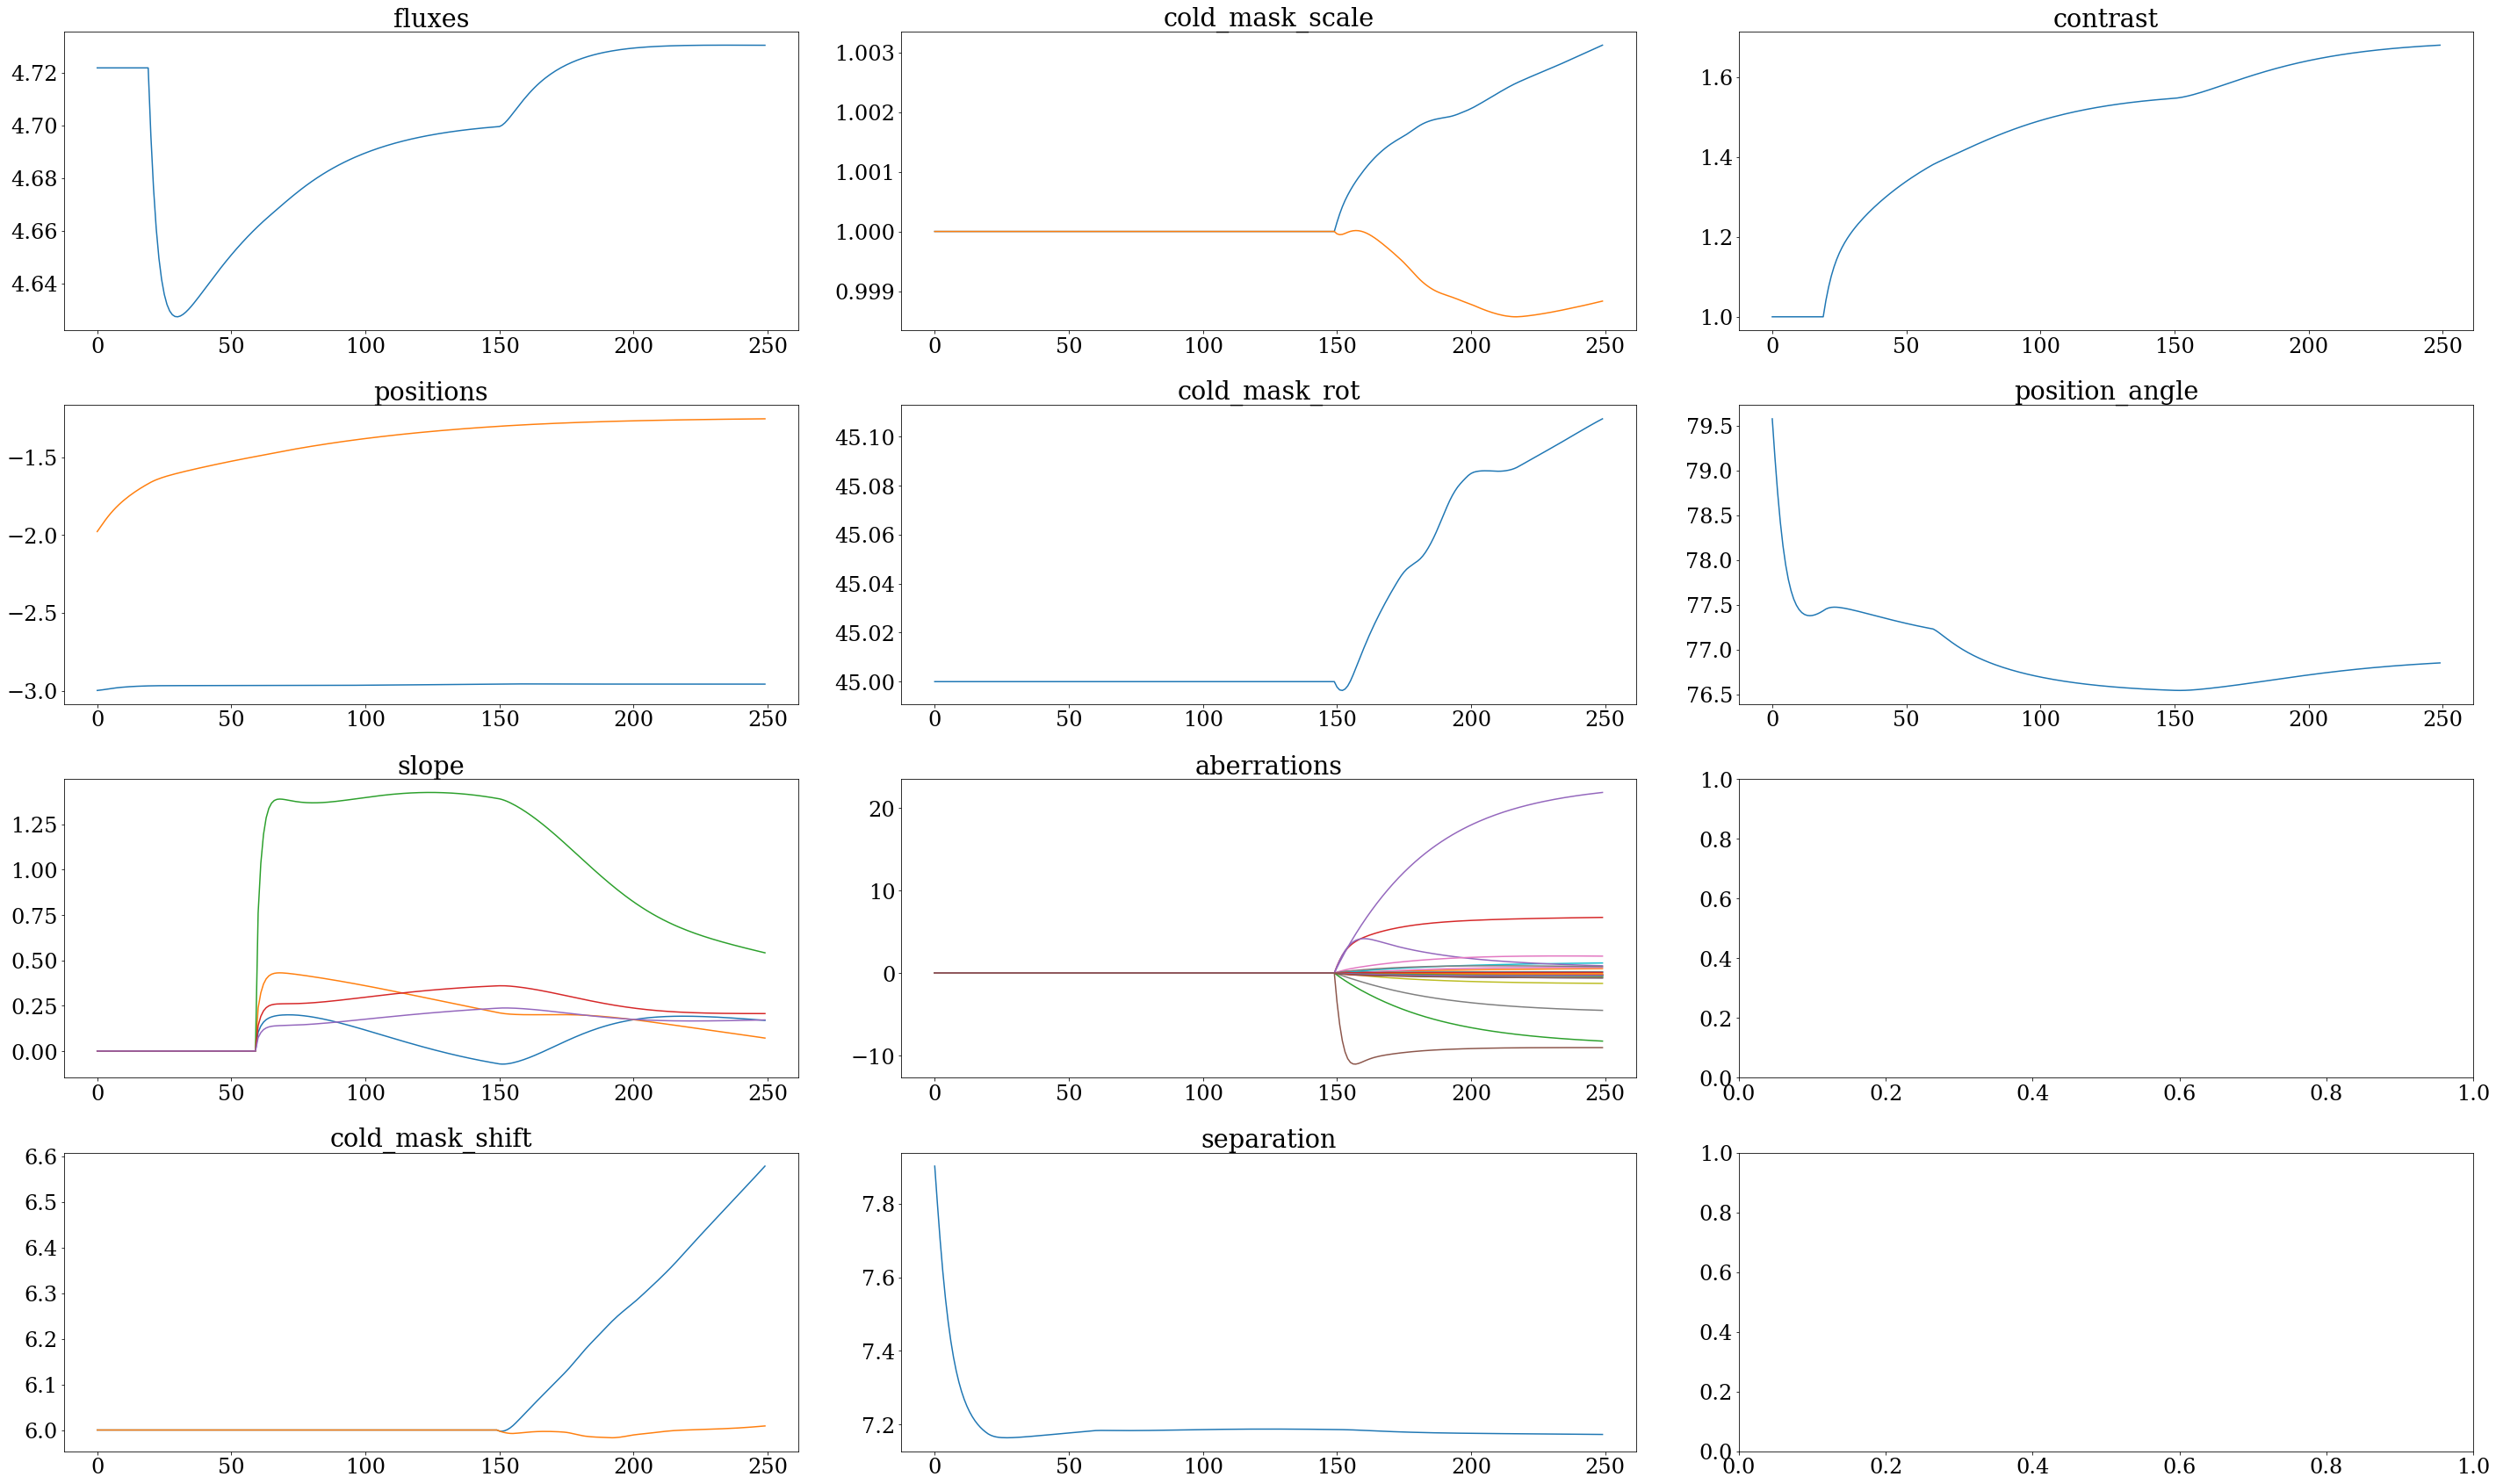

In [21]:
xw = 4
yw = int(np.ceil(len(groups)/xw))

print(len(groups))


fig, axs = plt.subplots(xw,yw,figsize=(xw*10,yw*8))
for i, param in enumerate(groups):
    #print(param)
    sp = axs[i%xw, i//xw]
    if param in ["fluxes", "contrast", "positions", "aberrations", 
                 "cold_mask_shift", "cold_mask_rot", "cold_mask_scale", "cold_mask_shear",
                 "primary_rot","primary_scale", "primary_shear", "slope"]:
        #print(np.asarray(list(models_s[0].get(param).values())))
        #print(injected_params[param])
        """for j in injected_params[param].values():
            print(j)
            print(len(j.shape))
            if len(j.shape)>0:
                for k in j:
                    sp.axhline(k, color='k', linestyle='--')
            else:
                sp.axhline(j, color='k', linestyle='--')"""
        for p in np.asarray([np.asarray(list(x.get(param).values())) for x in models]).T:
            if len(p.shape)>1:
                for i in range(p.shape[0]):
                    sp.plot(p[i,:])
            else:
                sp.plot(p)
            sp.set_title(param)
    else:
        sp.set_title(param)
        sp.plot([x.get(param) for x in models])
        #sp.axhline(injected_params[param], color='k', linestyle='--')

    
fig.tight_layout()

1.527195e+10, 1.137041e+08


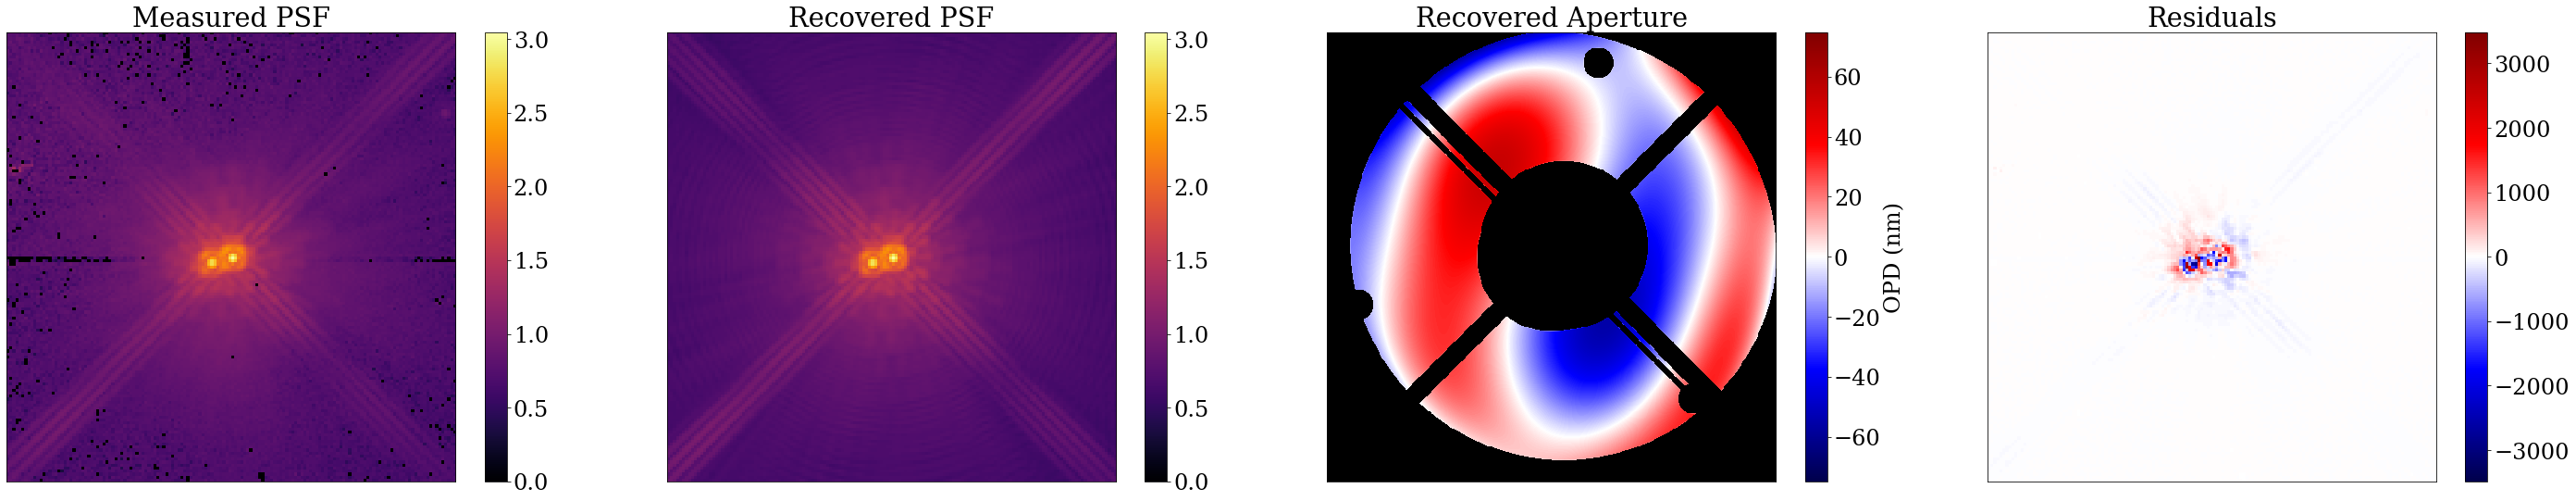

In [22]:
print(f"{float(losses[0]):e}, {float(losses[-1]):e}")

fig, axs = plt.subplots(1,4, figsize=(40,8))

fig.tight_layout()

cmap = matplotlib.colormaps['inferno']
cmap.set_bad('k',1)

#vm = max(np.max(cropped_data),np.max(telescope.model()))

exp = exposures[0]

model = params.inject(model)

coords = dlu.pixel_coords(512, 2.4)
cropped_frame = exp.data**0.125
telescope_frame = exp.fit(model,exp)**0.125

vm = max(np.nanmax(cropped_frame),np.nanmax(telescope_frame))
cd=axs[0].imshow(cropped_frame, vmin=0,vmax=vm,cmap=cmap)
plt.colorbar(cd,ax=axs[0])
tl=axs[1].imshow(telescope_frame, vmin=0, vmax=vm,cmap=cmap)
plt.colorbar(tl,ax=axs[1])
#axs[2].imshow(cropped_err)
cmap = matplotlib.colormaps['seismic']
cmap.set_bad('k',1)

optics = exp.fit.update_optics(model, exp)

support = optics.transmission(coords,2.4/512)
support_mask = support.at[support < .5].set(np.nan)

opd = optics.AberratedAperture.eval_basis(coords)*1e9
olim = np.max(np.abs(opd))
apt =axs[2].imshow(support_mask*opd,cmap=cmap,vmin=-olim, vmax=olim)
plt.colorbar(apt, ax=axs[2]).set_label("OPD (nm)")
#axs[4].imshow(telescope.detector.pixel_response.pixel_response)
resid = (exp.data - exp.fit(model,exp))/exp.err
rlim = np.nanmax(np.abs(resid))
resid=axs[3].imshow(resid, cmap='seismic',vmin=-rlim, vmax=rlim)
plt.colorbar(resid,ax=axs[3])

"""def pix2rad(x):
    return dlu.arcsec2rad(x*0.0432)

def rad2pix(x):
    return dlu.rad2arcsec(x)/0.0432

positions = dlu.positions_from_sep(
        pix2rad(model.get(exp.map_param("positions"))),
        pix2rad(model.params["separation"]),
        dlu.deg2rad(model.params["position_angle"])
    )

for i in range(2):
    x, y = rad2pix(positions[i]) + wid/2 - 0.5
    axs[3].axvline(x, color='gk'[i],linestyle='--')
    axs[3].axhline(y, color='gk'[i],linestyle='--')
"""

axs[0].set_title("Measured PSF")
axs[1].set_title("Recovered PSF")
axs[2].set_title("Recovered Aperture")
axs[3].set_title("Residuals")

for i in range(4):
    axs[i].set_xticks([])
    axs[i].set_yticks([])

#axs[1].imshow(telescope.optics.aberrations.eval_basis(coords)*1e9)
plt.show()
#plt.imshow(np.abs(telescope.model()-cropped_data)**0.25)


In [23]:
#resid = (exp.data - exp.fit(model,exp))/exp.data
#print(np.nanmedian(np.abs(resid[50:-50,50:-50])))
#plt.imshow((np.abs(resid[50:-50,50:-50])))
#plt.colorbar()

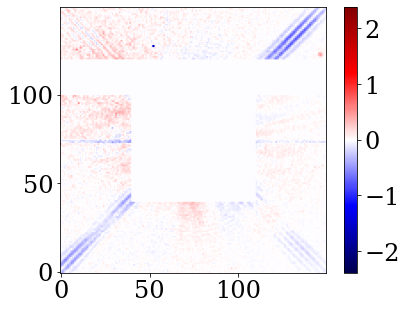

In [24]:
res = 0.0
for exp in exposures[:]:#[:10]+exposures[11:]:
    res = res + np.nan_to_num(exp.data - exp.fit(model, exp), 0.0)/len(exposures)


#res = res.at[50:100, 50:100].set(0.0)

#res = res.at[35:65, 35:65].set(0.0)

#res = res.at[40:90, 60:90].set(0.0)
res = res.at[40:110, 40:110].set(0.0)

res = res.at[100:120,:].set(0.0)

#res = res.at[50, 55:70].set(0.0)

#res = res.at[45:55,45:55].set(0.0)

#res = res.at[28:36,52:60].set(0.0)
res = res-np.mean(res)


m = np.max(np.abs(res))

plt.imshow(res, cmap='seismic', vmax=m, vmin=-m)
plt.colorbar()

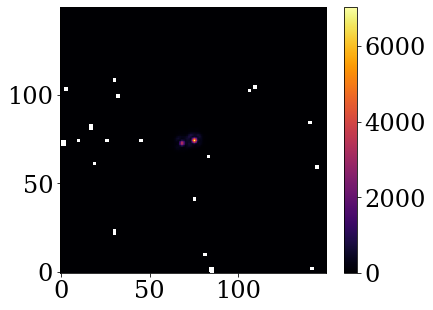

In [25]:
plt.imshow(exposures[0].data)
plt.colorbar()

In [26]:
np.nansum(res)/np.nansum(exposures[0].data)

Array(-5.356275e-09, dtype=float32)